In [1]:
# Imports

from OverwatchProcessData import get_competitive_rank, get_vector_gamestats, get_vector_herostats
from OverwatchProcessData import get_vector_combined, general_stats, hero_stats
from OverwatchGatherData import Player, find_usernames

import numpy as np
import os

np.random.seed(3)

from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# Load Data

## Creating Custom Metrics

general_general_stats = ["kpd"]

for stat in general_stats:

    if "avg" in stat:

        general_general_stats.append(stat)
        
general_hero_stats = []

for stat in hero_stats:

    if "avg" in stat:

        general_hero_stats.append(stat)
        
## Loading Data
        
def generate_players():
    
    for filename in os.listdir('profiles'):
        
        yield Player.from_file(os.path.join('profiles', filename))

def load_data(get_vector):

    unscaled_X, unscaled_y = [], []

    for player in generate_players():

        rank = get_competitive_rank(player, 'us')
        rank2 = get_competitive_rank(player, 'eu')

        if rank:

            unscaled_X.append(get_vector(player, 'us'))
            unscaled_y.append(rank)
            
        if rank2:
            
            unscaled_X.append(get_vector(player, 'eu'))
            unscaled_y.append(rank2)

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    print(unscaled_X.shape)
    print(unscaled_y.shape)
    
    return unscaled_X, unscaled_y


In [3]:
# Standardize Data

def scale_data(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler(with_mean=False) # SR is 1-5000 so scaling w/mean has weird effects

    X = scaler_X.fit_transform(unscaled_X)
    y = np.squeeze(scaler_y.fit_transform(unscaled_y.reshape(-1, 1)))
    
    return X, y, scaler_X, scaler_y

def scale_data2(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y / 5000
    
    return X, y, scaler_X


In [4]:
# Keras Model

def get_model(from_file=False):
    
    if not from_file:

        model = Sequential()
        model.add(Dense(40, input_dim=68, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(40, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(40, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))

        model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss b/c regression
        
    else:
        
        model = load_model(os.path.join('models', 'overwatch-sr-1.h5'))
    
    return model

def get_model2(from_file=False):
    
    if not from_file:
        
        model = Sequential()
        model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(13, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(13, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))

        model.compile(loss='mean_squared_error', optimizer='adam')
        
    else:
        
        model = load_model(os.path.join('models', 'overwatch-sr-2.h5'))
    
    return model

def get_model3(from_file=False):
    
    if not from_file:
        
        model = Sequential()
        model.add(Dense(8, input_dim=3090, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))

        model.compile(loss='mean_squared_error', optimizer='adam')
        
    else:
        
        model = load_model(os.path.join('models', 'overwatch-sr-3.h5'))
    
    return model

def get_model4(from_file=False):
    
    if not from_file:
        
        model = Sequential()
        model.add(Dense(8, input_dim=410, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, kernel_initializer='normal'))

        model.compile(loss='mean_squared_error', optimizer='adam')
        
    else:
        
        model = load_model(os.path.join('models', 'overwatch-sr-4.h5'))
    
    return model

def get_model5(from_file=False):
    
    if not from_file:
        
        model = Sequential()
        model.add(Dense(20, input_dim=3158, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(20, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))

        model.compile(loss='mean_squared_error', optimizer='adam')
        
    else:
        
        model = load_model(os.path.join('models', 'overwatch-sr-5.h5'))
    
    return model


In [5]:
# Learning function. Wrapper for keras model.fit( ... )

def train_model(model, *args, **kwargs):

    history = model.fit(*args, **kwargs, shuffle=True, verbose=0)
    
    return history


In [6]:
# Predict SR

def predict_sr(model, player):
    
    stats_vector = np.array([get_vector_gamestats(player, 'us')])
    
    X = scaler_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(scaler_y.inverse_transform(y_matrix))
    
    return int(sr)

def predict_sr2(model, player, scaler_for_X, get_vector):
    
    stats_vector = np.array([get_vector(player, 'us')])
    
    X = scaler_for_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix) * 5000
    
    return int(sr)


In [7]:
# Stats

def view(history):
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('Log(loss)')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    

(4305, 410)
(4305,)


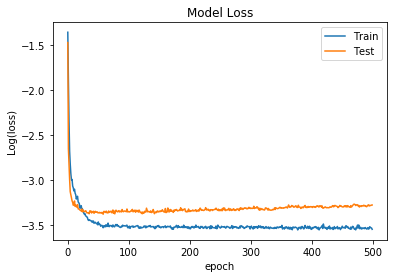

In [8]:
# Model 4

get_vector = lambda player, region : get_vector_herostats(player, region, stat_keys=general_hero_stats)

X, y, scaler_X = scale_data2(*load_data(get_vector))

model = get_model4()

history = train_model(model, X, y, epochs=500, batch_size=100, validation_split=.10)

model.save(os.path.join('models', 'overwatch-sr-4.h5'))

view(history)


In [ ]:

with open('test_names.txt', 'r') as test:

    for battletag in find_usernames(test.read()):
        
        player = Player.from_web_battletag(battletag)
        
        actual = get_competitive_rank(player, 'us')
        p = predict_sr2(model, player, scaler_X, get_vector)
        
        print("{} is {}, predicted {}".format(battletag, actual, p))
